# **Convolutional Neural Networks: Teaching a Machine to Recognize Objects**

### **Context**

The **CIFAR-10** (Canadian Institute For Advanced Research) dataset is a **collection of images with 10 different classes** representing airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. **CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects.**

The CIFAR-10 dataset consists of 60000 32x32x3 (i.e. color images) in 10 classes, with 6000 images per class. There are a total of 50000 training images and 10000 testing images. You can learn more about this dataset from here - https://www.cs.toronto.edu/~kriz/cifar.html

Since the images in CIFAR-10 are low-resolution (32x32x3), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of **Convolutional Neural Networks** tend to be the best at recognizing the images in CIFAR-10.

### **Objective**

In this project, we intend to build a multi-class classification algorithm to predict 10 different classes of the CIFAR-10 dataset using **Convolutional Neural Networks and Transfer Learning**.

### **Loading Libraries**

In [1]:
# Import the necessary tools for analysis as well as Keras
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Keras Sequential Model
from tensorflow.keras.models import Sequential

# Import all the different layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam

### **Importing and loading the CIFAR dataset**

The CIFAR dataset is already present in the Keras library in the form of an n-dimensional NumPy array. We will download this dataset from the Keras module here.

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
x_train.shape

(50000, 32, 32, 3)

Here the data is stored in a **4-dimensional NumPy array**.
- The first dimension **50000** is denoting **the number of images in the training data** where each image is stacked on top of the other as a 3-dimensional NumPy array. 
- The second dimension **32** is denoting **the number of pixels along the x-axis**
- The third dimension **32** is denoting **the number of pixels along the y-axis**
- The fourth dimension **3** is denoting **the total number of channels in those images** i.e. these are colored image consisting of RGB (Red, Green, and Blue) channels.

Below is a 3-dimensional NumPy representation of the first image in the training data. **Each pixel in an image has 3 values - the intensity of R, G, and B channels**, and the size of each image is 32x32. So, each image is represented by 32 arrays of shape 32x3.

In [5]:
# Print the numpy arrary representation of the first image
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [6]:
y_train[0]

array([6], dtype=uint8)

The target labels are encoded in numerical format. Here the encoding 6 denotes the category frog. **We will create a list of category names to convert the number to its original category name.**

In [7]:
x_test.shape

(10000, 32, 32, 3)

- There are **10,000 images in the test data** with the same last 3 dimensions as the training data.

### **Converting NumPy arrays to images and visualizing some random images**

As we saw above, all the images are stored as NumPy arrays, and values in the array denote the pixel intensities of the image. We can use matplotlib's **imshow()** function to visualize the image from NumPy arrays. Below we are plotting a few random images from the dataset, to see how the images look.

In [8]:
num_classes = 10

# Create a list of category names in alphabetical order
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

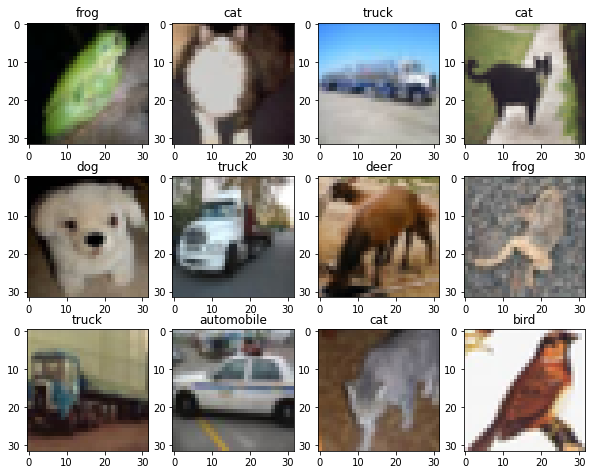

In [9]:
# Print the first 12 images in the training data along with their categorical labels
rows = 3
cols = 4
fig = plt.figure(figsize=(10, 8))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

### **Data Preparation**

In neural networks it is always suggested to **normalize the feature inputs**. Normalization has the following benefits while training a neural networks model: 

1. Normalization makes the **training faster** and **reduces the liklihood of getting stuck at local optima.**
2. Weight decay and estimation can be done more conveniently with normalized inputs.
3. In deep neural networks, **normalization helps to avoid exploding gradient problems.** (A gradient exploding problem occurs when large error gradients accumulate and result in very large updates to neural network model weights during training. This makes a model unstable and unable to learn properly from the training data.)

As we know image pixel **values range from 0-255**, here we are simply **dividing all the pixel values by 255 to standardize all the images to have values between 0-1.**

In [10]:
# Normalize the image pixels by dividing by 255
x_train_normalized = x_train/255
x_test_normalized = x_test/255

Since this is a **10 class classification problem**, the output layer should have **10 neurons** which will provide us with the probabilities of the input image belonging to each of those 10 classes. Therefore, we also need to create a **one-hot encoded representation for the target classes.**

In [11]:
# Create a one-hot encoded representation of target classification labels
# API for the utility function in use: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

### **Model Building**

Let's now create a CNN model sequentially where we will be adding the layers one after another

First, let's **set the seed for random number generators in NumPy, Python, and TensorFlow** to be able to reproduce the same results every time we run the code.

In [12]:
# Fix the seed for random number generators for repeatability
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

Let's build a **CNN model with Leaky Rectified Linear Unit (LeakyRelu)** as the activation function. LeakyReLU is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. The slope coefficient is determined before training, i.e. it is not learned during training.

**Note:**
- In Keras, The input features be 4-dimensional to build a CNN model.
- Here, we have already have 4-dimensional input as these are colored images.
- In the case of grayscale images, we must reshape the input features to specifically mention that we have only 1 channel i.e. gray

In [13]:
# Initialize a sequential model
model_1 = Sequential()

# Add the first convolutional layer with 16 filters and kernel size 3x3, padding 'same' ensures the output size
# is the same as the input size, and input_shape denotes input image dimension of CIFAR images
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(32, 32, 3)))

# Add a leaky relu activation function with negative slope of 0.1
model_1.add(LeakyReLU(0.1))

# Add a second convolutional layer with 32 filters and with kernel size 3x3
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))

# Add a leaky relu activation function with negative slope of 0.1
model_1.add(LeakyReLU(0.1))
    
# Add a max pooling layer to reduce the size of output of second convolutional layer
model_1.add(MaxPooling2D(pool_size=(2, 2)))
    
# Flatten the 3-D output of the convolutional layer after max pooling to prepare it for creating dense connections
model_1.add(Flatten())

# Add a fully connected dense layer with 256 neurons    
model_1.add(Dense(256))

# Add a leaky relu activation function with negative slope of 0.1
model_1.add(LeakyReLU(0.1))

# Add the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model_1.add(Dense(10, activation='softmax'))

In [14]:
# Print the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

As we can see from the above summary, this CNN model will train and learn **2,105,066 parameters (weights and biases).**

Let's now compile and train the model using the train data. Here, we are using the loss function - **categorical_crossentropy** as this is a multi-class classification problem. We will try to minimize this loss at every iteration using the **optimizer** of our choice. Also, we are choosing **accuracy** as the metric to measure the performance of the model.

In [15]:
# Compile the model
model_1.compile(
    loss='categorical_crossentropy',
    # Set the learning rate of the adamax optimizer to 0.005 (Default is 0.001)
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.005),
    metrics=['accuracy']
)

In [16]:
# Fit the model with 10 epochs and a validation split of 0.1
history_1 = model_1.fit(
            x_train_normalized, y_train_encoded,
            epochs=10,
            validation_split=0.1,
            shuffle=True,
            verbose=2
)

Epoch 1/10
1407/1407 - 38s - loss: 1.3558 - accuracy: 0.5165 - val_loss: 1.0648 - val_accuracy: 0.6248
Epoch 2/10
1407/1407 - 8s - loss: 0.9255 - accuracy: 0.6734 - val_loss: 0.9170 - val_accuracy: 0.6894
Epoch 3/10
1407/1407 - 8s - loss: 0.6957 - accuracy: 0.7544 - val_loss: 0.9250 - val_accuracy: 0.6940
Epoch 4/10
1407/1407 - 8s - loss: 0.4825 - accuracy: 0.8318 - val_loss: 0.9557 - val_accuracy: 0.7048
Epoch 5/10
1407/1407 - 8s - loss: 0.2902 - accuracy: 0.9001 - val_loss: 1.0941 - val_accuracy: 0.6986
Epoch 6/10
1407/1407 - 8s - loss: 0.1578 - accuracy: 0.9476 - val_loss: 1.3604 - val_accuracy: 0.6978
Epoch 7/10
1407/1407 - 8s - loss: 0.0874 - accuracy: 0.9717 - val_loss: 1.6374 - val_accuracy: 0.6926
Epoch 8/10
1407/1407 - 8s - loss: 0.0531 - accuracy: 0.9826 - val_loss: 1.8648 - val_accuracy: 0.7008
Epoch 9/10
1407/1407 - 8s - loss: 0.0331 - accuracy: 0.9903 - val_loss: 2.0729 - val_accuracy: 0.6920
Epoch 10/10
1407/1407 - 8s - loss: 0.0291 - accuracy: 0.9904 - val_loss: 2.0795 -

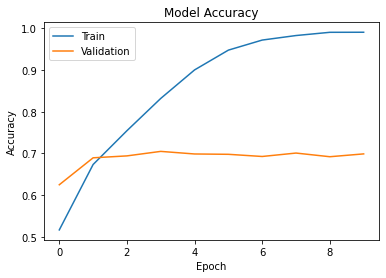

In [17]:
# Plot the accuracies
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** 

- We can see from the accuracy plot that the model has done poorly on the validation data. This heavily suggests that the model is highly overfitting the training data. 
- Notice that the validation accuracy has become more or less constant after 2 epochs.

Let's try adding few dropout layers to the model structure to attempt to reduce overfitting and to see if this improves the model.

First we will need to clear the previous model's history from the session. In Keras, we need a special command to clear the model's history otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

In [18]:
# Clear the backend
from tensorflow.keras import backend
backend.clear_session()

In [19]:
# Fix the seed for random number generators for repeatability
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [20]:
# Initialize a sequential model
model_2 = Sequential()

# Add the first convolutional layer with 16 filters and a kernel size of 3x3,
# set padding as 'same' to provide the output in the size same as the input
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(32, 32, 3)))

# Add a leaky relu activation function with negative slope of 0.1
model_2.add(LeakyReLU(0.1))

# Add a dropout to randomly switch off 20% neurons to reduce overfitting
model_2.add(Dropout(0.2))

# Add a second convolutional layer with 32 filters and with kernel size 3x3
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))

# Add a leaky relu activation function with negative slope of 0.1
model_2.add(LeakyReLU(0.1))

# Add a dropout to randomly switch off 20% neurons to reduce overfitting
model_2.add(Dropout(0.2))
    
# Add a max pooling layer to reduce the size of output of second convolutional layer
model_2.add(MaxPooling2D(pool_size=(2, 2)))
    
# Flatten the 3-D output of the convolutional layer after max pooling to make it ready for creating dense connections
model_2.add(Flatten())

# Add a fully connected dense layer with 256 neurons    
model_2.add(Dense(256))

# Add a leaky relu activation function with negative slope of 0.1
model_2.add(LeakyReLU(0.1))

# Add dropout to randomly switch off 50% neurons to reduce overfitting
model_2.add(Dropout(0.5))

# Add the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model_2.add(Dense(10, activation='softmax'))

In [21]:
# Print the model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [22]:
# Compile the model with the same optimizer and learning rate
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.005), 
    metrics=['accuracy']
)

In [23]:
# Fit the model over 10 epochs with a validation split of 0.1
history_2 = model_2.fit(
            x_train_normalized, y_train_encoded,
            epochs=10,
            validation_split=0.1,
            shuffle=True,
            verbose=2
)

Epoch 1/10
1407/1407 - 10s - loss: 1.5525 - accuracy: 0.4458 - val_loss: 1.7347 - val_accuracy: 0.4242
Epoch 2/10
1407/1407 - 9s - loss: 1.1788 - accuracy: 0.5820 - val_loss: 1.2068 - val_accuracy: 0.5908
Epoch 3/10
1407/1407 - 9s - loss: 1.0201 - accuracy: 0.6416 - val_loss: 1.2190 - val_accuracy: 0.5992
Epoch 4/10
1407/1407 - 9s - loss: 0.9201 - accuracy: 0.6767 - val_loss: 1.1475 - val_accuracy: 0.6208
Epoch 5/10
1407/1407 - 9s - loss: 0.8415 - accuracy: 0.7056 - val_loss: 1.1590 - val_accuracy: 0.6292
Epoch 6/10
1407/1407 - 9s - loss: 0.7743 - accuracy: 0.7270 - val_loss: 1.1803 - val_accuracy: 0.6326
Epoch 7/10
1407/1407 - 9s - loss: 0.7156 - accuracy: 0.7487 - val_loss: 1.0658 - val_accuracy: 0.6740
Epoch 8/10
1407/1407 - 9s - loss: 0.6646 - accuracy: 0.7666 - val_loss: 0.9978 - val_accuracy: 0.6812
Epoch 9/10
1407/1407 - 9s - loss: 0.6189 - accuracy: 0.7808 - val_loss: 1.1321 - val_accuracy: 0.6596
Epoch 10/10
1407/1407 - 9s - loss: 0.5851 - accuracy: 0.7958 - val_loss: 1.0413 -

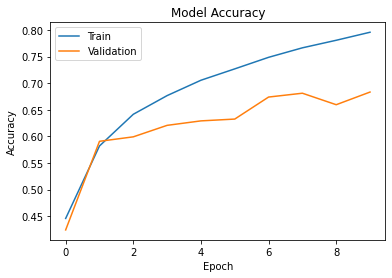

In [24]:
# Plot the accuracies
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** 

- The second model with dropout layers seems to have reduced the overfitting as compared to the previous model but still, the model is not performing well on the validation data. 
- The validation accuracy has even decreased slightly when compared to the previous model.

Now we will build another model with a few more convolutional layers, max-pooling layers, and dropout layers to further reduce overfitting. We will also change the learning rate and the number of epochs and see if the model's performance improves.

In [25]:
# Clear the backend
from tensorflow.keras import backend
backend.clear_session()

In [26]:
# Fix the seed for random number generators for repeatability
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [27]:
# Initialize a sequential model
model_3 = Sequential()

# Add the first convolutional layer with 16 filters and kernel size of 3x3,
# set padding as 'same' to provide the output as the same size as the input
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(32, 32, 3)))

# Add a leaky relu activation function with negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Add a second convolutional layer with 32 filters and with kernel size 3x3
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))

# Add a leaky relu activation function with negative slope of 0.1
model_3.add(LeakyReLU(0.1))
    
# Add a max pooling layer to reduce the size of output of second conv layer
model_3.add(MaxPooling2D(pool_size=(2, 2)))
    
# Add dropout to randomly switch off 25% of the network to reduce overfitting
model_3.add(Dropout(0.25))
    
# Add a third convolutional layer with 32 filters and with kernel size 3x3
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))

# Add a leaky relu activation function with negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Add a fourth convolutional layer with 64 filters and with kernel size 3x3
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))

# Add a leaky relu activation function with negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Add a max pooling layer to reduce the size of output of fourth conv layer    
model_3.add(MaxPooling2D(pool_size=(2, 2)))
    
# Add dropout to randomly switch off 25% of the network to reduce overfitting
model_3.add(Dropout(0.25))

# Flatten the 3-D output of the convolutional layer after max pooling to make it ready for creating dense connections
model_3.add(Flatten())

# Add a fully connected dense layer with 256 neurons    
model_3.add(Dense(256))

# Add a leaky relu activation function with negative slope of 0.1
model_3.add(LeakyReLU(0.1))
    
# Add dropout to randomly switch off 50% of dense layer neurons to reduce overfitting
model_3.add(Dropout(0.5))

# Add the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model_3.add(Dense(10, activation='softmax'))

In [28]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9

In this new architecture, although **the number of convolutional layers has increased** but the **total number of trainable parameters has reduced significantly (~50%)**. This is due to the addition of few **max-pooling layers in between**. Let's train this model.

In [29]:
# Compile the model with the same optimizer, but now with a learning rate of 0.001
model_3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    metrics=['accuracy']
)

In [30]:
# Fit the model over 15 epochs with a validation split of 0.1
history_3 = model_3.fit(
            x_train_normalized, y_train_encoded,
            epochs=15,
            validation_split=0.1,
            shuffle=True,
            verbose=2
)

Epoch 1/15
1407/1407 - 13s - loss: 1.6286 - accuracy: 0.4093 - val_loss: 1.3088 - val_accuracy: 0.5276
Epoch 2/15
1407/1407 - 12s - loss: 1.2694 - accuracy: 0.5457 - val_loss: 1.0683 - val_accuracy: 0.6280
Epoch 3/15
1407/1407 - 12s - loss: 1.1072 - accuracy: 0.6064 - val_loss: 0.9577 - val_accuracy: 0.6670
Epoch 4/15
1407/1407 - 12s - loss: 1.0038 - accuracy: 0.6460 - val_loss: 0.8917 - val_accuracy: 0.6942
Epoch 5/15
1407/1407 - 12s - loss: 0.9235 - accuracy: 0.6759 - val_loss: 0.8347 - val_accuracy: 0.7142
Epoch 6/15
1407/1407 - 12s - loss: 0.8632 - accuracy: 0.6955 - val_loss: 0.7782 - val_accuracy: 0.7302
Epoch 7/15
1407/1407 - 12s - loss: 0.8113 - accuracy: 0.7152 - val_loss: 0.7696 - val_accuracy: 0.7326
Epoch 8/15
1407/1407 - 12s - loss: 0.7716 - accuracy: 0.7301 - val_loss: 0.7236 - val_accuracy: 0.7516
Epoch 9/15
1407/1407 - 12s - loss: 0.7392 - accuracy: 0.7408 - val_loss: 0.7294 - val_accuracy: 0.7498
Epoch 10/15
1407/1407 - 12s - loss: 0.6971 - accuracy: 0.7544 - val_loss:

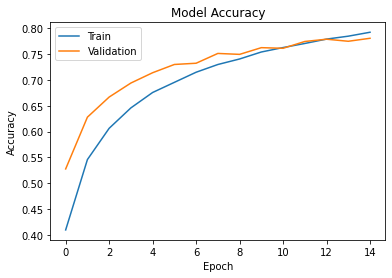

In [31]:
# Plot the accuracies
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** 

- The third iteration of this model seems very promising now.
- **The validation accuracy has improved substantially** and the problem of **overfitting has been reduced** completely. We can say that the **model is giving a generalized performance.** 
- The above plot shows that **the validation accuracy is higher than the training accuracy**. There are a few possible reasons for this:
    - The **size of the validation set may not be big enough**
    - We may have **imbalanced data in the validation set**
    - **High regularization**. If we use regularization methods such as L2, L1, or Dropout, while the model calculates training accuracy it uses a regularized model, but when it tests accuracy on the validation set, it processes the data through an unregularized model. Regularization introduces some noise in loss value during training. As a result, the training accuracy decreases more than expected, but while evaluating the model, the model doesn't use regularization hence there is no noise. This is why the validation accuracy doesn't decrease.
    - **To overcome this, we can try to reduce the regularization or increase the size of the validation set.**

**We can try out some more iterations and tune some of the hyperparameters** to further improve the model **but hyperparameter tuning is exhaustive** and can take a long time to find the right set of values for each hyperparameter.

**Let's try some other techniques like transfer learning** to see if we can speed up the process of training the model, and can also get a more accurate model overall.

### **Transfer Learning**

**Transfer learning** is a popular deep learning technique that **reuses a pre-trained model on a new problem**. **It can train deep neural networks with comparatively little data.** This is very useful in the data science field since most real-world problems typically do not have millions of labeled data points to train complex models.

Let's begin by clearing the backend and fixing the seed.

In [32]:
# Clear the backend
from tensorflow.keras import backend
backend.clear_session()

In [33]:
# Fix the seed for random number generatorsfor repeatability
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

We will use VGG16 as the pre-trained model. You can read about it [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16).

Also, we will use the **Functional Model API** to build the model this time because it allows explicitly connecting the output of one layer to the input of another layer. Each connection is specified. You can read about it [here](https://www.tensorflow.org/guide/keras/functional).

In [34]:
# Import the necessary libraries to utilize VGG16
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16

Now, let's instantiate the VGG16 model.

- The **VGG16 model was originally trained on images of size 224 x 224**. The **TensorFlow application allows the minimum image size of 32x32** which is luckily the same as the image size in the CIFAR-10 dataset. If you want to use any other size, you can change the size of the input image.
- By specifying the argument **include_top=False**, we can load a network that **doesn't include the classification layers at the top** (i.e. we will use the VGG16 model only for feature extraction).

In [35]:
# Initialize the VGG16 model with max pooling and an input shape that reflects the size of images in the CIFAR-10 dataset
vgg_model = VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3), pooling='max')

58900480/58889256 [==============================] - 1s 0us/step


In [36]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

- The VGG16 model has **more than 14.7M trainable parameters.** 
- Here, **we will not train any of the layers from the VGG16 model**. We will use the pre-trained weights and biases.
- Also, we can take any layer's output from the VGG16 model as the input of our new model. Here, **we will take the output of the 3rd block of the VGG16 model as the input of our new model.**

In [37]:
# Obtain the output of the third block of the VGG16 model
transfer_layer = vgg_model.get_layer('block3_pool')

In [38]:
vgg_model.trainable=False

We will now add classification layers to our model using Functional Model API

In [40]:
# Add classification layers on top of it

# Flatten the output from the transfer layer from the VGG16 model
x = Flatten()(transfer_layer.output)
# Add a fully connected dense layer with 256 neurons and a relu activation function
x = Dense(256, activation='relu')(x)
# Add a fully connected dense layer with 128 neurons and a relu activation function
x = Dense(128, activation='relu')(x)
# Add dropout layer to randomly switch off 30% of the neurons
x = Dropout(0.3)(x)
# Add a fully connected dense layer with 64 neurons and a relu activation function
x = Dense(64, activation='relu')(x)
# Add a batch normalization
x = BatchNormalization()(x)
# Add an output layer with 10 nodes for classification using the softmax function, as this is a multi-class problem
pred = Dense(10, activation='softmax')(x)

# Initialize the model
model_4 = Model(vgg_model.input, pred)

In [41]:
# Compile the model using categorical crossentropy loss function and the adamax optimizer with learning rate 0.005
model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0005),
              metrics=['accuracy'])

In [42]:
# Fit the model with 10 epochs and a validation split of 0.1
history_4 = model_4.fit(
            x_train_normalized, y_train_encoded,
            epochs=10,
            batch_size=250,
            validation_split=0.1,
            verbose=2
)

Epoch 1/10
180/180 - 8s - loss: 1.4518 - accuracy: 0.5100 - val_loss: 0.9745 - val_accuracy: 0.6704
Epoch 2/10
180/180 - 6s - loss: 1.0058 - accuracy: 0.6604 - val_loss: 0.8264 - val_accuracy: 0.7204
Epoch 3/10
180/180 - 6s - loss: 0.8572 - accuracy: 0.7106 - val_loss: 0.7573 - val_accuracy: 0.7428
Epoch 4/10
180/180 - 6s - loss: 0.7763 - accuracy: 0.7362 - val_loss: 0.7102 - val_accuracy: 0.7604
Epoch 5/10
180/180 - 6s - loss: 0.7073 - accuracy: 0.7587 - val_loss: 0.6803 - val_accuracy: 0.7670
Epoch 6/10
180/180 - 6s - loss: 0.6549 - accuracy: 0.7773 - val_loss: 0.6539 - val_accuracy: 0.7736
Epoch 7/10
180/180 - 6s - loss: 0.6092 - accuracy: 0.7931 - val_loss: 0.6366 - val_accuracy: 0.7808
Epoch 8/10
180/180 - 6s - loss: 0.5744 - accuracy: 0.8042 - val_loss: 0.6548 - val_accuracy: 0.7752
Epoch 9/10
180/180 - 6s - loss: 0.5329 - accuracy: 0.8157 - val_loss: 0.6638 - val_accuracy: 0.7688
Epoch 10/10
180/180 - 6s - loss: 0.4993 - accuracy: 0.8288 - val_loss: 0.6136 - val_accuracy: 0.7952

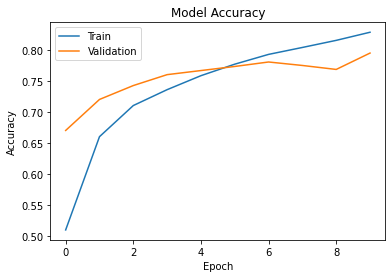

In [43]:
# Plot the accuracies
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**

- The model **training accuracy is slightly higher than the validation accuracy**.
- The **validation accuracy has improved as compared to the previous model**.
- We have been able to achieve the **best validation accuracy so far without actually training any of the convolutional layers.** There are other pre-trained models as well which can be tried and/or tuned to get better performance.

We will now use this model to make predictions on the testing data.

### **Making predictions**

In [44]:
# Make predictions on the testing data using model 4
y_pred_test = model_4.predict(x_test_normalized)

# Convert probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Calculate the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

              precision    recall  f1-score   support

           0       0.85      0.78      0.82      1000
           1       0.90      0.86      0.88      1000
           2       0.70      0.71      0.71      1000
           3       0.62      0.60      0.61      1000
           4       0.73      0.78      0.75      1000
           5       0.73      0.63      0.67      1000
           6       0.78      0.87      0.82      1000
           7       0.83      0.83      0.83      1000
           8       0.85      0.90      0.88      1000
           9       0.82      0.87      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



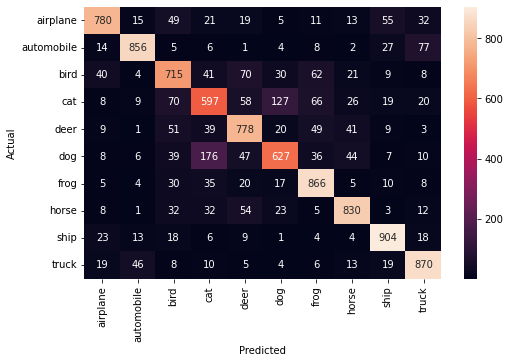

In [45]:
# Import required functions for classification reports and confusion matrices
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Print the classification report
print(classification_report(y_test, y_pred_test_classes))

# Plot the heatmap using a confusion matrix
cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:**

- The model is giving about **78% accuracy on the test data** which is **comparable to the accuracy of the validation data.** This implies that the model is giving a generalized performance.
- The **recall has a high range** which implies that the **model is good at identifying some objects while poor at identifying some other objects**. For example, the **model is able to identify more than 90% of ships but can only identify only 63% dogs**.
- The model **shows significant confusion between cats and dogs**. This implies that the **model might be focused on features related to shapes and sizes but not deep features of objects** that can help to distinguish between objects like cats and dogs.
- Consequently **precision also has a high range with 'cat' class having the least precision.**
- The **highest precision is for the 'horse' class**, which implies that the model is quite able to distinguish horses from other objects. 

### **Visualizing predicted images**

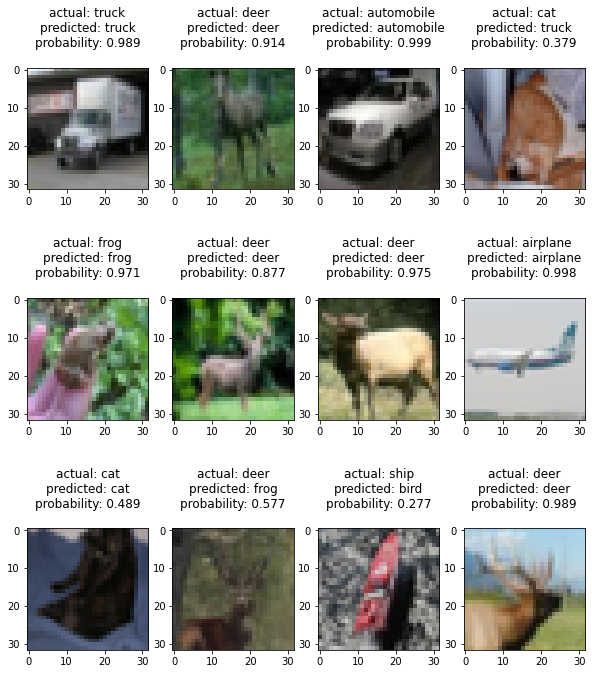

In [46]:
# Print 12 randomly selected images and their predicted labels from the testing data
rows = 3
cols = 4
fig = plt.figure(figsize=(10, 12))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba
        ))
plt.show()

### **Conclusion**

In this project we have **implemented a CNN model from scratch** and **utilized transfer learning to make predictions on the CIFAR-10 dataset.** We have also learned how to prepare image data before passing it into a CNN model and how to add layers sequentially inside the model.

We have experimented with 4 different iterations of the CNN model and built some intuition about how to improve these types of models by tuning various hyperparameters and using different approaches to model structure. There is still plenty of room for improvement and we can continue to tune different hyperparameters in the future to further improve the model performance.